<center><h1>Chen_Shufen_Final_Project</h1></center>
<br>
<br>

Name: Shufen Chen
<br>
Github Username: shufench-usc
<br>
USC ID: 9180940635

Package imports

In [ ]:
import tensorflow as tf

## (b) Data Exploration and Pre-processing

### i. One-hot encoding for classes

In [622]:
"""read csv files and combine them into test and train data sets"""

# create column names
column_names = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']

# create empty lists to storn traiin data and test data
train_ls = []
test_ls = []

# split train and test data sets
for i in range(len(all_files)):
    for j in range(len(all_files[i])):
        if i < 2 and re.search('dataset(1|2)(\D)', all_files[i][j]):  # bending1 and bending2: dataset 1 and 2 (test data)
            df = pd.read_csv(all_files[i][j], names=column_names, skiprows=5, engine='python')  # rename columns and skip first 5 rows (metadata)
            test_ls.append(df)
        elif i >= 2 and re.search('dataset(1|2|3)(\D)', all_files[i][j]):  # other folders: dataset 1, 2 and3 (test data)
            df = pd.read_csv(all_files[i][j], names=column_names, skiprows=5, engine='python')
            test_ls.append(df)
        else:  #other datasets (train data)
            df = pd.read_csv(all_files[i][j], sep=',|\s', names=column_names, skiprows=5, engine='python') 
            train_ls.append(df)

# merge data frams into training and test data sets
train_df = pd.concat(train_ls, ignore_index=True)
test_df = pd.concat(test_ls, ignore_index=True)

# print and check the data sets
print(train_df)
print(test_df)


         time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0           0      42.00       0.00      18.50       0.50      12.00   
1         250      42.00       0.00      18.00       0.00      11.33   
2         500      42.75       0.43      16.75       1.79      18.25   
3         750      42.50       0.50      16.75       0.83      19.00   
4        1000      43.00       0.82      16.25       0.83      18.00   
...       ...        ...        ...        ...        ...        ...   
33114  118750      31.50       1.66      12.50       3.20      14.25   
33115  119000      27.33       1.25      11.33       0.94      20.00   
33116  119250      37.80       7.68      14.20       2.48      17.25   
33117  119500      33.75       1.30      15.75       5.21      16.50   
33118  119750      32.67       3.09      18.67       0.47      14.00   

       var_rss23  
0           0.00  
1           0.94  
2           0.43  
3           1.22  
4           0.00  
...          ...  
33

### (c) Feature Extraction

#### i. Research

Time-domain features usually used in time series classification include:
 maximum, minimum, mean, median, standard deviation, variance, quartiles (Q1, Q3), interquartile range (IQR), peak-to-peak distance (max-min), area under the curve (AUC), entropy, zero crossing rate, mean/median absolute differences, autocorrelation.
 
 For more features, see Appendix in this paper: https://www.sciencedirect.com/science/article/pii/S2352711020300017?via%3Dihub


#### ii. Extraction

In [623]:
def extract_time_domain_features(all_files, normalized=False):
    """
    This function extracts time-domain features from the csv files.
    If normalized is True, the time series will be z-score normalized before feature extraction.
    
    Parameters:
        all_files (list): a 2D list containing the file paths of all csv files
        normalized (bool): whether to z-score normalize the time series before feature extraction
    
    Returns:
        df_summary (DataFrame): a dataframe containing the extracted features for each instance
        """

    # save all csv file paths into a list
    files_list = list((f for files in all_files for f in files))  # convert 2D list to 1D list

    # create dictionaries for time series labels and statistics labels
    ts_label = {1: 'avg_rss12', 2: 'var_rss12', 3: 'avg_rss13', 4: 'var_rss13', 5: 'avg_rss23', 6: 'var_rss23'}
    stats = {'min':'min', 'max':'max', 'mean':'mean', 'median':'50%', 'standard deviation':'std', '1st quart':'25%', '3rd quart':'75%'}

    # create an empty list to store the rows of the summary dataframe
    rows = []

    # for each instance, calculate the time-domain features
    for file in range(len(files_list)):
        df = pd.read_csv(files_list[file], sep=',|\s', names=column_names, skiprows=5, engine='python')
        if normalized:
            df = (df - df.mean()) / df.std(ddof=0)  # z-score normalization, use population standard deviation (ddof=0)
            df_stats = df.describe().loc[stats.values(), ts_label.values()]  # get the statistics for the 6 time series
            row = [df_stats.loc[stat, ts] for ts in ts_label.values() for stat in stats.values() ]  # flatten the dataframe to a list
            rows.append(row)
        else:
            df_stats = df.describe().loc[stats.values(), ts_label.values()]  
            row = [df_stats.loc[stat, ts] for ts in ts_label.values() for stat in stats.values() ]  
            rows.append(row)

    # convert the list of rows to a dataframe
    df_summary = pd.DataFrame(rows, columns=[f'{stat}{ts}' for ts in ts_label.keys() for stat in stats.keys()])
    df_summary.insert(0, 'instance', range(1, 89))

    return df_summary

In [624]:
# extract time-domain features without normalization
df_wo_norm = extract_time_domain_features(all_files, normalized=False)
display(df_wo_norm.style.hide(axis="index"))

instance,min1,max1,mean1,median1,standard deviation1,1st quart1,3rd quart1,min2,max2,mean2,median2,standard deviation2,1st quart2,3rd quart2,min3,max3,mean3,median3,standard deviation3,1st quart3,3rd quart3,min4,max4,mean4,median4,standard deviation4,1st quart4,3rd quart4,min5,max5,mean5,median5,standard deviation5,1st quart5,3rd quart5,min6,max6,mean6,median6,standard deviation6,1st quart6,3rd quart6
1,36.250000,48.000000,43.969125,44.500000,1.618364,43.310000,44.670000,0.000000,1.500000,0.413125,0.470000,0.263111,0.430000,0.500000,1.500000,26.330000,15.868021,16.250000,3.742420,14.250000,18.000000,0.000000,5.170000,0.666354,0.470000,0.788985,0.000000,0.940000,11.330000,30.750000,22.103750,21.670000,3.318301,20.500000,23.750000,0.000000,2.960000,0.555312,0.490000,0.487826,0.000000,0.830000
2,37.000000,48.000000,43.454958,43.250000,1.386098,42.500000,45.000000,0.000000,1.580000,0.378083,0.470000,0.315566,0.000000,0.500000,5.750000,27.000000,15.793333,15.000000,3.847638,13.000000,18.270000,0.000000,10.030000,0.849354,0.500000,0.995761,0.430000,1.120000,8.000000,33.500000,23.034792,23.500000,2.488862,22.250000,24.000000,0.000000,5.260000,0.679646,0.500000,0.622534,0.430000,0.870000
3,33.000000,47.750000,42.179812,43.500000,3.670666,39.150000,45.000000,0.000000,3.000000,0.696042,0.500000,0.630860,0.000000,1.120000,8.500000,30.000000,22.183625,23.000000,3.810469,20.500000,24.372500,0.000000,5.150000,0.989917,0.830000,0.953730,0.430000,1.300000,20.000000,38.670000,33.493917,35.000000,3.849448,30.457500,36.330000,0.000000,2.180000,0.613521,0.500000,0.524317,0.000000,1.000000
4,33.000000,45.750000,41.678063,41.750000,2.243490,41.330000,42.750000,0.000000,2.830000,0.535979,0.500000,0.405469,0.430000,0.710000,3.000000,28.250000,19.006563,19.125000,4.087107,16.500000,22.062500,0.000000,6.420000,0.841875,0.500000,0.928801,0.430000,1.120000,23.670000,37.500000,29.857083,30.000000,2.411026,28.457500,31.250000,0.000000,1.790000,0.383292,0.430000,0.389164,0.000000,0.500000
5,37.250000,45.000000,40.624792,40.500000,1.476967,39.250000,42.000000,0.000000,1.300000,0.358604,0.430000,0.322605,0.000000,0.500000,4.000000,29.500000,19.040937,19.250000,4.462952,16.000000,23.250000,0.000000,7.230000,0.832542,0.500000,0.965659,0.000000,1.120000,27.250000,38.250000,34.311292,35.000000,2.188449,33.000000,36.000000,0.000000,1.920000,0.570583,0.430000,0.582915,0.000000,1.300000
6,38.000000,45.670000,42.812812,42.500000,1.435550,42.000000,43.670000,0.000000,1.220000,0.372437,0.470000,0.289158,0.000000,0.500000,2.000000,29.500000,20.096979,21.000000,3.893737,19.000000,22.250000,0.000000,5.760000,0.876438,0.500000,1.047259,0.000000,1.145000,27.670000,38.500000,33.024583,33.000000,1.995255,32.000000,34.500000,0.000000,3.110000,0.571083,0.430000,0.601010,0.000000,1.300000
7,35.000000,47.400000,43.954500,44.330000,1.558835,43.000000,45.000000,0.000000,1.700000,0.426250,0.470000,0.338690,0.000000,0.500000,6.500000,29.750000,22.122354,23.000000,3.030943,19.750000,24.000000,0.000000,4.440000,0.497312,0.430000,0.550657,0.000000,0.830000,29.000000,38.500000,35.588458,36.000000,1.999604,35.362500,36.500000,0.000000,1.790000,0.493292,0.430000,0.513506,0.000000,0.940000
8,25.000000,47.500000,31.058250,29.710000,4.829794,27.500000,31.812500,0.000000,6.380000,0.405458,0.430000,0.566668,0.000000,0.500000,2.000000,28.330000,15.296667,15.000000,4.841975,13.000000,17.750000,0.000000,5.320000,0.823542,0.500000,0.902248,0.000000,1.120000,0.000000,40.330000,14.407188,13.000000,7.853427,9.000000,18.312500,0.000000,4.920000,1.098104,0.940000,0.831480,0.500000,1.300000
9,27.500000,33.000000,29.881938,30.000000,1.153837,29.000000,30.270000,0.000000,1.000000,0.256437,0.000000,0.275833,0.000000,0.470000,0.000000,14.500000,8.166250,8.750000,3.403613,5.500000,11.250000,0.000000,4.440000,0.544646,0.470000,0.644369,0.000000,0.710000,11.000000,23.250000,18.117896,18.000000,1.745970,17.000000,19.000000,0.000000,6.400000,0.701625,0.710000,0.481103,0.470000,0.940000
10,19.000000,45.500000,30.9

In [625]:
# extract time-domain features with z-score normalization
df_w_norm = extract_time_domain_features(all_files, normalized=True) 
display(df_w_norm.style.hide(axis="index"))

instance,min1,max1,mean1,median1,standard deviation1,1st quart1,3rd quart1,min2,max2,mean2,median2,standard deviation2,1st quart2,3rd quart2,min3,max3,mean3,median3,standard deviation3,1st quart3,3rd quart3,min4,max4,mean4,median4,standard deviation4,1st quart4,3rd quart4,min5,max5,mean5,median5,standard deviation5,1st quart5,3rd quart5,min6,max6,mean6,median6,standard deviation6,1st quart6,3rd quart6
1,-4.774686,2.493309,0.000000,0.328374,1.001043,-0.407704,0.433528,-1.571793,4.135172,0.000000,0.216389,1.001043,0.064203,0.330528,-3.843238,2.798428,0.000000,0.102174,1.001043,-0.432797,0.570274,-0.845453,5.714110,-0.000000,-0.249129,1.001043,-0.845453,0.347195,-3.250154,2.608344,-0.000000,-0.130851,1.001043,-0.483809,0.496630,-1.139528,4.934536,0.000000,-0.134024,1.001043,-1.139528,0.563672
2,-4.661787,3.282440,-0.000000,-0.148021,1.001043,-0.689673,1.115833,-1.199360,3.812734,0.000000,0.291579,1.001043,-1.199360,0.386745,-2.612983,2.915648,0.000000,-0.206402,1.001043,-0.726744,0.644357,-0.853859,9.229343,0.000000,-0.351207,1.001043,-0.421579,0.272081,-6.047131,4.209203,-0.000000,0.187111,1.001043,-0.315650,0.388216,-1.092880,7.365276,-0.000000,-0.288873,1.001043,-0.401434,0.306092
3,-2.503467,1.519070,0.000000,0.360034,1.001043,-0.826273,0.769106,-1.104472,3.655900,0.000000,-0.311077,1.001043,-1.104472,0.672733,-3.594807,2.053429,0.000000,0.214469,1.001043,-0.442303,0.575036,-1.039025,4.366458,-0.000000,-0.167850,1.001043,-0.587693,0.325466,-3.509073,1.346033,-0.000000,0.391655,1.001043,-0.789616,0.737519,-1.171354,2.990773,-0.000000,-0.216738,1.001043,-1.171354,0.737879
4,-3.872144,1.816895,-0.000000,0.032098,1.001043,-0.155305,0.478298,-1.323255,5.663604,-0.000000,-0.088827,1.001043,-0.261647,0.429632,-3.920441,2.263968,-0.000000,0.029009,1.001043,-0.613925,0.748482,-0.907356,6.011994,-0.000000,-0.368466,1.001043,-0.443911,0.299758,-2.568839,3.173292,0.000000,0.059338,1.001043,-0.581098,0.578330,-0.985937,3.618461,-0.000000,0.120147,1.001043,-0.985937,0.300208
5,-2.287331,2.965383,-0.000000,-0.084580,1.001043,-0.931792,0.932074,-1.112750,2.921153,-0.000000,0.221541,1.001043,-1.112750,0.438752,-3.373693,2.345975,0.000000,0.046893,1.001043,-0.682084,0.944096,-0.863048,6.631879,0.000000,-0.344727,1.001043,-0.863048,0.297992,-3.229986,1.801650,0.000000,0.315030,1.001043,-0.599813,0.772451,-0.979865,2.317359,-0.000000,-0.241424,1.001043,-0.979865,1.252630
6,-3.356089,1.992385,0.000000,-0.218132,1.001043,-0.566794,0.597737,-1.289349,2.934193,0.000000,0.337753,1.001043,-1.289349,0.441611,-4.652564,2.417429,0.000000,0.232158,1.001043,-0.282023,0.553522,-0.837760,4.668052,-0.000000,-0.359825,1.001043,-0.837760,0.256711,-2.686459,2.747083,0.000000,-0.012334,1.001043,-0.514046,0.740234,-0.951198,4.228826,-0.000000,-0.234989,1.001043,-0.951198,1.214086
7,-5.750347,2.212610,-0.000000,0.241136,1.001043,-0.612955,0.671393,-1.259837,3.764733,-0.000000,0.129309,1.001043,-1.259837,0.217978,-5.159666,2.519217,0.000000,0.289864,1.001043,-0.783528,0.620139,-0.904067,7.167436,0.000000,-0.122368,1.001043,-0.904067,0.604795,-3.298319,1.457578,0.000000,0.206026,1.001043,-0.113119,0.456337,-0.961637,2.527840,-0.000000,-0.123383,1.001043,-0.961637,0.870826
8,-1.255658,3.407786,0.000000,-0.279444,1.001043,-0.737498,0.156329,-0.716260,10.554285,-0.000000,0.043354,1.001043,-0.716260,0.167012,-2.748990,2.694547,0.000000,-0.061334,1.001043,-0.474819,0.507209,-0.913719,4.988817,0.000000,-0.358969,1.001043,-0.913719,0.328920,-1.836424,3.304272,-0.000000,-0.179368,1.001043,-0.689231,0.497794,-1.322040,4.601292,0.000000,-0.190346,1.001043,-0.720075,0.243068
9,-2.066515,2.705161,-0.000000,0.102428,1.001043,-0.765149,0.336674,-0.930653,2.698509,-0.000000,-0.930653,1.001043,-0.930653,0.775053,-2.401792,1.862832,0.000000,0.171688,1.001043,-0.784176,0.906968,-0.846121,6.051529,-0.000000,-0.115964,1.001043,-0.846121,0.256882,-4.081010,2.942466,0.000000,-0.067595,1.001043,-0.640940,0.505750,-1.459889,11.856757,0.000000,0.017426,1.001043,-0.481948,0.495993
10,-1.55522

The means are closed to 0 and standard deviation are closed to 1 after Z-score normalization. The scale across features becomes comparable. 

Since describe() reports the sample standard deviation (ddof=1) while the z-score normalization uses the population standard deviation (ddof=0), the standard deviation of the standardized features is not exactly 1.

#### iii. Standard Deviation

In [626]:
def estimate_std_ci(df):
    """ 
    This function estimates the standard deviation and 90% confidence interval for each time-domain feature using bootstrap method. 
    
    Parameters:
        df (DataFrame): a dataframe containing the extracted features for each instance
    
    Returns:
        df_ci (DataFrame): a dataframe containing the standard deviation and 90% confidence interval for each time-domain feature
    """

    #  drop the "instance" column
    df = df.drop(columns='instance')

    # convert the dataframe to a numpy array and transpose it
    numpy_data = df.to_numpy().T  

    # calculate the 90% confidence interval for the standard deviation using bootstrap method
    res = bootstrap((numpy_data,), np.std, confidence_level=0.9,axis=1, method='basic')

    std = np.std(numpy_data, axis=1, ddof=0) # use population standard deviation (ddof=0)
    ci_low = res.confidence_interval.low
    ci_high = res.confidence_interval.high

    # create a dataframe to display the standard deviation and 90% confidence interval for each time-domain feature
    df_ci = pd.DataFrame({'Time-domain feature':df.columns, 'Standard Deviation':std, '90%CI_low':ci_low, '90%CI_high':ci_high})

    return df_ci

In [627]:
# estimate standard deviation of time-domain features without normalization
df_ci = estimate_std_ci(df_wo_norm)
display(df_ci)

,Time-domain feature,Standard Deviation,90%CI_low,90%CI_high
0,min1,9.515445,8.302978,10.828792
1,max1,4.369322,3.472933,5.409618
2,mean1,5.305314,4.769047,5.924030
3,median1,5.409056,4.856241,6.045893
4,standard deviation1,1.762056,1.585310,1.966562
5,1st quart1,6.118526,5.635191,6.691768
6,3rd quart1,5.109643,4.420182,5.910708
7,min2,0.000000,0.000000,0.000000
8,max2,5.033882,4.696277,5.465747
9,mean2,1.565194,1.434651,1.738928


In [628]:
# estimate standard deviation of time-domain features with normalization
df_norm_ci = estimate_std_ci(df_w_norm)
display(df_norm_ci)

,Time-domain feature,Standard Deviation,90%CI_low,90%CI_high
0,min1,2.526789e+00,1.355964e+00,3.670354e+00
1,max1,1.247785e+00,9.405211e-01,1.609794e+00
2,mean1,1.626525e-14,8.575059e-15,2.768235e-14
3,median1,3.143553e-01,2.792511e-01,3.545718e-01
4,standard deviation1,2.312226e-07,6.658599e-08,4.624451e-07
5,1st quart1,2.977872e-01,2.472251e-01,3.561711e-01
6,3rd quart1,2.937840e-01,2.493361e-01,3.448945e-01
7,min2,6.259452e-01,5.249278e-01,7.427178e-01
8,max2,3.098652e+00,2.654994e+00,3.629572e+00
9,mean2,1.503661e-16,1.312073e-16,1.718848e-16


#### iv. Select Features

In [629]:
def plot_std_ci(df_ci):
    """
    This function is to plot the standard deviation with 90% confidence interval for each time-domain feature.
  
    Parameters:
        df_ci (DataFrame): a dataframe containing the standard deviation and 90% confidence interval for each time-domain feature
    
    Returns:
        None
    """

    # calculate the width of the confidence interval and sort the dataframe by the width
    df = df_ci.copy()
    df['ci_width'] = df['90%CI_high'] - df['90%CI_low']
    df_sorted = df.sort_values(by='ci_width', ascending=True)
    
    # set the figure size
    plt.figure(figsize=(8, 10))

    # plot horizontal error bars
    plt.errorbar(
        x=df_sorted['Standard Deviation'].to_numpy(),
        y=np.arange(len(df_sorted)),
        xerr=[df_sorted['ci_width']/2, df_sorted['ci_width']/2],
        fmt='o',
        markersize=4,
        markerfacecolor='red',
        markeredgecolor='red',
        ecolor='blue',
        capsize=4
    )

    #  set components of the plot
    plt.yticks(np.arange(len(df_sorted)), df_sorted['Time-domain feature'])
    plt.xlabel('Standard Deviation')
    plt.ylabel('Time-domain Feature')
    plt.title('Standard Deviation with 90% Confidence Interval for Time-Domain Features')
    plt.grid()
    plt.tight_layout()
    plt.show()

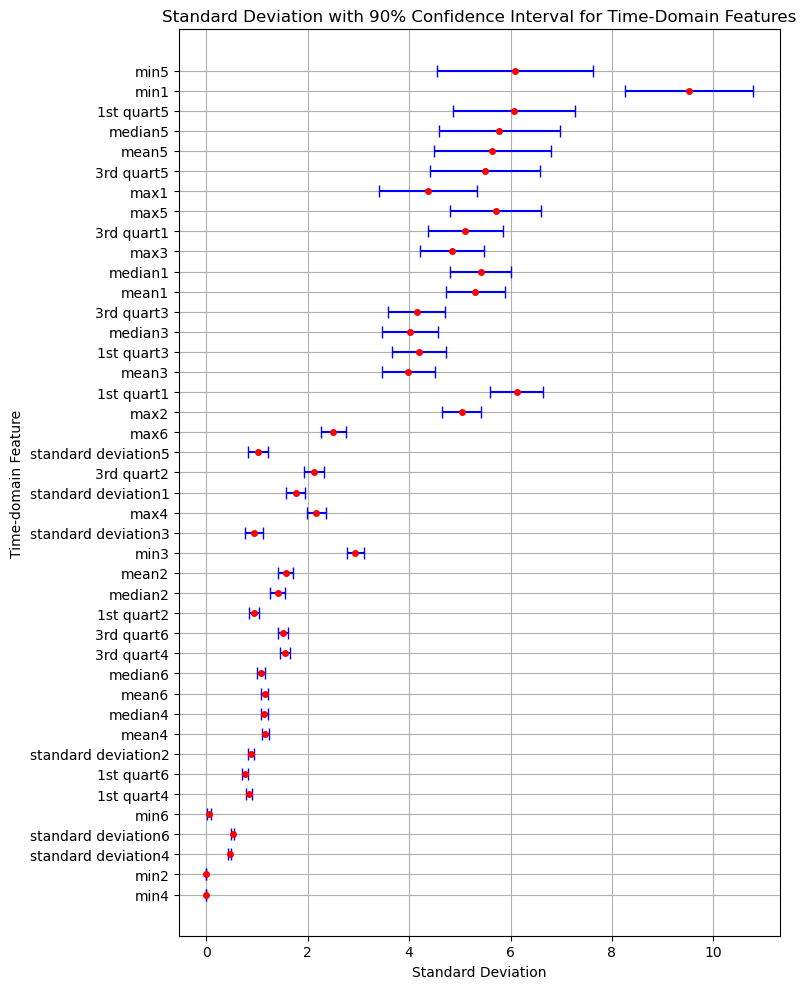

In [630]:
# plot standard deviation with 90% confidence interval for each time-domain feature without normalization
plot_std_ci(df_ci) 

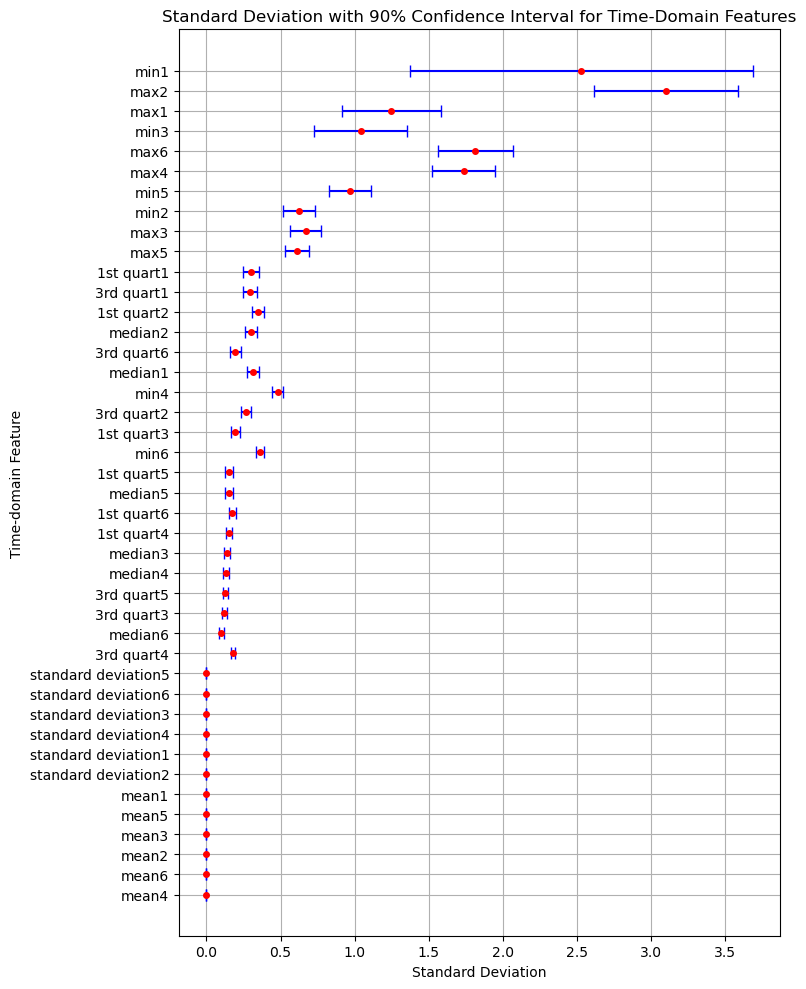

In [631]:
# plot standard deviation with 90% confidence interval for each time-domain feature with normalization
plot_std_ci(df_norm_ci) 

I will choose the median, IQR and standard deviation.


## 2. ISLR 3.7.4

### (a) Linear Train

The training residual sum of squares(RSS) of the linear regression will be higher than that of the cubic regression. Since the cubic regression has more cofficients to estimate, it is more flexible and can fit data better.

### (b) Linear Test

The test RSS of the linear regression will be lower than the cubic regression. The true relationship between X and Y is linear, so the linear regression estimate will be unbiased. Although the cubic regression could be seen as linear regression, there are more flexibility when it comes to predict unseen data, which might be overfitted. Therefore, the test RSS of linear regression will be lower. 

### (c) Not Linear Train

Since the true relationship between X and Y is nonlinear and we don't know how far it is from linear. If the the deviation of true relationship from linear relationship is small, the training RSS of cubic model will still be lower since it is more flexible. The training RSS of cubic regression will be much lower if the true relationship is extremely nonlinear and can be estimated well by cubic regression model.

### (d) Not Linear Testing

There is not enough information to tell. The test RSS difference between linear and cubic regression depends on the true relationship between X and Y. If the true relationship is extremely nonlinear and can be approximated well by the cubic regression model, the test RSS of cubic regression might be lower. However, if the deviation of true relationship from linear relationship is modest or small, the linear regression model might have a lower RSS due to the smaller variance with a small sample size (n=100 observations).

## 3. ISLR 3.7.3 - Extra Practice 

### (a) Which answer is correct, and why?

The third one is correct: for a fixed value of IQ and GPA, high school graduates earn more, on average, than college graduates provided that the GPA is high enough.


Suppose Y represents the starting salary after graduation (in thousands of dollars). The linear model will be: 
$$Y = \beta_0 + \beta_1 X_{1} + \beta_2 X_{2} + \beta_3 X_{3} + \beta_4 X_{4} + \beta_5 X_{5} + \epsilon$$

For high school graduates ($X_{3}$ = 0):
$$\hat{Y} = \hat\beta_0 + \hat\beta_1 X_{1} + \hat\beta_2 X_{2} + \hat\beta_4 X_{4}$$

For college graduates ($X_{3}$ = 1):
$$\hat{Y} = \hat\beta_0 + (\hat\beta_1 + \hat\beta_5) X_{1} + \hat\beta_2 X_{2} + \hat\beta_3 + \hat\beta_4 X_{4}$$

In this case, the fitted regression models:
<br>$\hat{Y}_{highschool}$ = 50 + 20 x GPA + 0.07 x IQ  + 0.01 x GPA x IQ
<br>$\hat{Y}_{college}$ = 50 + 10 x GPA + 0.07 x IQ  + 0.01 x GPA x IQ + 35
<br>$\hat{Y}_{highschool} - \hat{y}_{college}$ = 10 x GPA - 35

With a fixed value of IQ and GPA, when GPA > 3.5, $\hat{Y}_{highschool}$ > $\hat{Y}_{college}$, otherwise, $\hat{Y}_{highschool}$ <= $\hat{Y}_{college}$


### (b) Salary prediction

$\hat{Y}_{college}$ = 50 + 10 x 4.0 + 0.07 x 110  + 0.01 x 4.0 x 110 + 35 = 137.1
<br>The predicted atarting salary of a college graduate with IQ of 110 and a GPA of 4.0 is $137,100

### (c) True or False

False
<br>The interaction effect should be assessed using the coefficient's p-value and confidence interval, or hypothesis test, instead of the magnitude of the interaction term. Besides, the interaction effect size depends on the scales of GPA, IQ and starting salary, so the small number does not imply a small effect.

## 3. ISLR 3.7.5 - Extra Practice 

$$\hat{\beta} = \frac{\displaystyle\sum_{i=1}^n x_{i} y_{i}}{\displaystyle\sum_{i'=1}^n x_{i'}^2}$$

$$
\hat{y}_{i} 
= x_{i}\hat{\beta}
= x_{i} \frac{\displaystyle\sum_{j=1}^n x_{j} y_{j}} {\displaystyle\sum_{k=1}^n x_{k}^2}
= \frac{\displaystyle\sum_{j=1}^n x_{i} x_{j} y_{j}} {\displaystyle\sum_{k=1}^n x_{k}^2}
= \displaystyle\sum_{j=1}^n \frac{ x_{i} x_{j} y_{j}} {\displaystyle\sum_{k=1}^n x_{k}^2}
= {\displaystyle\sum_{i'=1}^n a_{i'} y_{i'}} 
$$

$$
a_{i'}
= \frac{x_{i} x_{j}} {\displaystyle\sum_{k=1}^n x_{k}^2}
$$

## Reference

1. Re: https://docs.python.org/3/library/re.html#regular-expression-syntax
2. pandas.read_csv (parameters): https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html
3. bootstrap: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.bootstrap.html
4. Barandas, M., Folgado, D., Fernandes, L., Santos, S., Abreu, M., Bota, P., ... & Gamboa, H. (2020). TSFEL: Time series feature extraction library. SoftwareX, 11, 100456. https://www.sciencedirect.com/science/article/pii/S2352711020300017?via%3Dihub
5. matplotlib.pyplot.errorbar: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.errorbar.html
